# South African Language Identification Hackathon Challenge 2022
### EDSA 2201 & 2207

© Explore Data Science Academy

---
### Honour Code

I { **MICHAEL OKEREAFOR** }, confirm - by submitting this document - that the solutions in this notebook are a result of our own work and that we abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

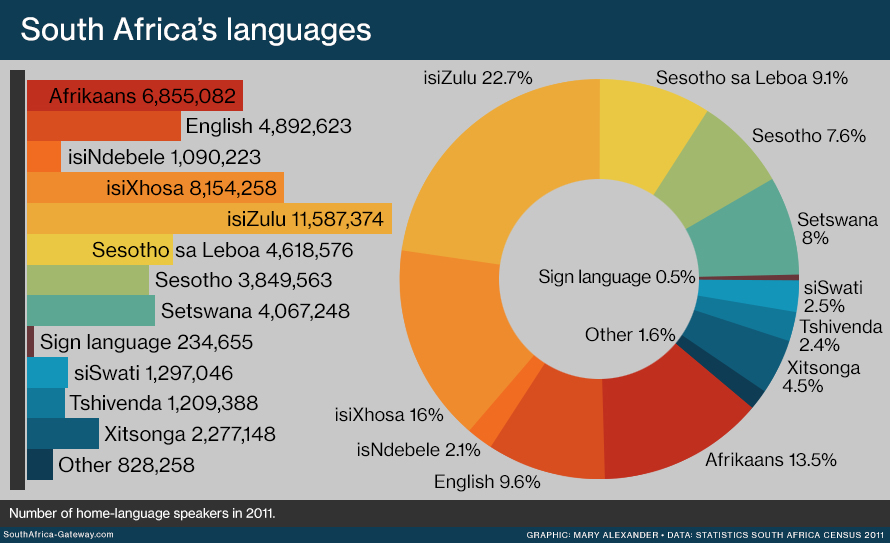

## Exam Overview: Climate Change Belief Analysis

According to Kaggle, South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.

EDSA is challenging me during with the following tasks; 

- analyse the supplied data;
- perform data engineering with Natural Language Processing.
- create Machine Learning models that are able to classify South African Languages based on the text document given.
- evaluate the `F1_score` of the best classification model.
- Submit my predicted test set to Kaggle before 24th June 2022, @ 8:00pm SAST


<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

In [1]:
from comet_ml import Experiment

In [2]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="ROjbHRdIYvME1efnooXTYhCeg",
    project_name="edsa-language-classification-hackathon-2022-challenge",
    workspace="chuqudee",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\PANDORA' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/chuqudee/edsa-language-classification-hackathon-2022-challenge/5fe8648fde6a4d3da82644b1baf5bbcb



 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>


In [41]:
# Libraries for data loading, wrangling, manipulation and visulisation
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Natural Language Tool Kit for processing and preparing unstructured text data
import nltk
import re
# For removing punctuation
import string

# sklearn(classifier)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Metrics/Evaluation and classification report
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from collections import Counter 
from sklearn import metrics

# Imbalanced data sampling
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Feature selection and scaling
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn import feature_selection
from sklearn.feature_selection import f_classif

import warnings
import pickle
warnings.filterwarnings('ignore') # just to turn off or ignore minor warnings that may pop-up while executing codes.


ModuleNotFoundError: No module named 'scikitplot'

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



### Climate Change Belief Data

The dataset used for this challenge is the **NCHLT Text Corpora** collected by the **South African Department of Arts and Culture & Centre for Text Technology** (CTexT, North-West University, South Africa). The training set was improved through additional cleaning done by Praekelt.

The data is in the form Language ID, Text. The text is in various states of cleanliness. Some NLP techniques will be necessary to clean up the data.

The dataset contains 1 features and 1 target label. 
Here is a quick explanation of the columns in the datasets: 

`lang_id` — the unique id of the South African languages.

`text` — a statement or text in South African language.


Below shows the description of the classes in the target label:

### Class Description     
**afr** - Afrikaans     
**eng** - English     
**nbl** - isiNdebele     
**nso** - Sepedi     
**sot** - Sesotho     
**ssw** - siSwati     
**tsn** - Setswana     
**tso** - Xitsonga     
**ven** - Tshivenda     
**xho** - isiXhosa     
**zul** - isiZulu    

So lets get started with our challenge!

In [4]:
# load train data and view first few entries
lang_data_train = pd.read_csv('train_set.csv')
lang_data_test = pd.read_csv('test_set.csv')
lang_data_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


Checking the number of observations and features of our loaded data

In [5]:
#Investigating the shape of the data
print('''
The shape of our data is {} 
'''.format(lang_data_train.shape))


The shape of our data is (33000, 2) 



Now lets investigate the data type stored in each column and check if there are any missing values.

In [6]:
# Data type
lang_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


We can also notice that our data has no null or missing values.

<a id="three"></a>
## 3. Preprocessing / Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In this section, We will look at the distribution of the target label which will be illustrated using graphs.

### Distribution of the target label

Let us calculate and visualize the count of each of the unique lang_id in our target label.

In [7]:
# Create class distribution dataframe
language_count = pd.DataFrame(list(lang_data_train['lang_id'].value_counts()),
                          index=[ 'Afrikaans', 'English', 'isiNdebele', 'Sepedi', 'Sesotho', 
                                 'siSwati', 'Setswana', 'Xitsonga', 'Tshivenda', 'isiXhosa', 'isiZulu'],
                          columns=['language count'])
language_count

,language count
Afrikaans,3000
English,3000
isiNdebele,3000
Sepedi,3000
Sesotho,3000
siSwati,3000
Setswana,3000
Xitsonga,3000
Tshivenda,3000
isiXhosa,3000


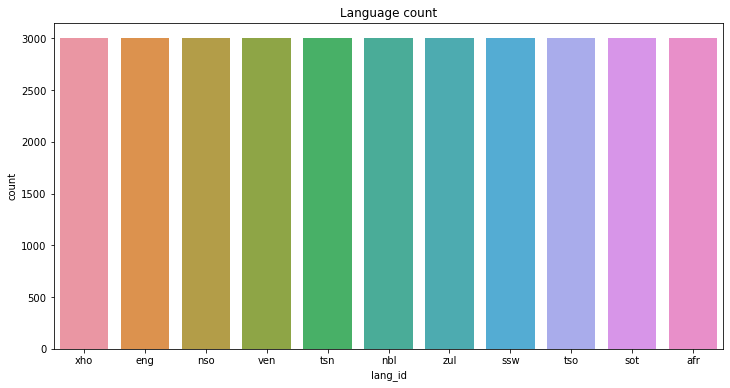

In [8]:
# Creating a class distribution in a dataframe
fig, axis = plt.subplots(figsize=(12, 6))
axis = sns.countplot(x='lang_id', data=lang_data_train)
plt.title('Language count')
plt.show()

Beautiful. Our Target label is 100% balanced! Which is very very rare in datasets! 

### Cleaning our text data

Although our text feature is made up of different languages, it could still contain unstructured and untidy words with numbers and punctuation marks. I will use some of our imported packages such as `nltk` to cleanup and seperate words in this feature.

In [9]:
# convert text to lower case in another column
lang_data_train['lowercase_text'] = lang_data_train['text'].str.lower()  
lang_data_test['lowercase_text'] = lang_data_test['text'].str.lower()  
lang_data_test.head(5)

,index,text,lowercase_text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele...","mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.,tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...,kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.,winste op buitelandse valuta.


Let us remove every punctuation marks. We really do not need them.

In [10]:
# creating a function to remove punctuations
def remove_punctuation(text):
    return ''.join([l for l in text if l not in string.punctuation])

In [11]:
# remove punctuation marks from text feature in another column
lang_data_train['punct_removed_text'] = lang_data_train['text'].apply(remove_punctuation)
lang_data_test['punct_removed_text'] = lang_data_test['text'].apply(remove_punctuation)
lang_data_test.head(5)

,index,text,lowercase_text,punct_removed_text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele...","mmasepala, fa maemo a a kgethegileng a letlele...",Mmasepala fa maemo a a kgethegileng a letlelel...
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,uzakwaziswa ngokufaneleko nakungafuneka eminye...,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.,tshivhumbeo tshi fana na ngano dza vhathu.,Tshivhumbeo tshi fana na ngano dza vhathu
3,4,Kube inja nelikati betingevakala kutsi titsini...,kube inja nelikati betingevakala kutsi titsini...,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.,winste op buitelandse valuta.,Winste op buitelandse valuta


Our data is looking clean.  
However, there may be numbers among these words. Lets write a code that will search for and remove numbers.

In [12]:
# removing digits from text feature in another column
lang_data_train['digit_removed_text'] = lang_data_train['text'].str.replace('\d+', '')
lang_data_test['digit_removed_text'] = lang_data_test['text'].str.replace('\d+', '')
lang_data_test.head(5)

,index,text,lowercase_text,punct_removed_text,digit_removed_text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele...","mmasepala, fa maemo a a kgethegileng a letlele...",Mmasepala fa maemo a a kgethegileng a letlelel...,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,uzakwaziswa ngokufaneleko nakungafuneka eminye...,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.,tshivhumbeo tshi fana na ngano dza vhathu.,Tshivhumbeo tshi fana na ngano dza vhathu,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...,kube inja nelikati betingevakala kutsi titsini...,Kube inja nelikati betingevakala kutsi titsini...,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.,winste op buitelandse valuta.,Winste op buitelandse valuta,Winste op buitelandse valuta.


In [13]:
# performing all the cleanup in another column
all_clean = lang_data_train['text'].str.lower()
    
def remove_punctuation(text):
    return ''.join([l for l in text if l not in string.punctuation])
    
all_clean = lang_data_train['text'].apply(remove_punctuation)

all_clean = lang_data_train['text'].str.replace('\d+', '')   

In [14]:
lang_data_train['all_clean_text'] = all_clean
lang_data_test['all_clean_text'] = all_clean

In [15]:
lang_data_train.head(5)

,lang_id,text,lowercase_text,punct_removed_text,digit_removed_text,all_clean_text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqosiseko wenza amalungiselelo kumaziko axh...,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,i-dha iya kuba nobulumko bokubeka umsebenzi na...,idha iya kuba nobulumko bokubeka umsebenzi nap...,i-dha iya kuba nobulumko bokubeka umsebenzi na...,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...,the province of kwazulu-natal department of tr...,the province of kwazulunatal department of tra...,the province of kwazulu-natal department of tr...,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,o netefatša gore o ba file dilo ka moka tše le...,o netefatša gore o ba file dilo ka moka tše le...,o netefatša gore o ba file dilo ka moka tše le...,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...


### Visualization by each Language

Let us create and analyse subsets of our dataframe on each of the languages.  

In [16]:
# Create subsets of tweeter_df by Sentiments
Afrikaans = lang_data_train[lang_data_train['lang_id'] == 'afr']['all_clean_text']
English = lang_data_train[lang_data_train['lang_id'] == 'eng']['all_clean_text']
isiNdebele = lang_data_train[lang_data_train['lang_id'] == 'nbl']['all_clean_text']
Sepedi = lang_data_train[lang_data_train['lang_id'] == 'nso']['all_clean_text']
Sesotho = lang_data_train[lang_data_train['lang_id'] == 'sot']['all_clean_text']
siSwati = lang_data_train[lang_data_train['lang_id'] == 'ssw']['all_clean_text']
Setswana = lang_data_train[lang_data_train['lang_id'] == 'tsn']['all_clean_text']
Xitsonga = lang_data_train[lang_data_train['lang_id'] == 'tso']['all_clean_text']
Tshivenda = lang_data_train[lang_data_train['lang_id'] == 'ven']['all_clean_text']
isiXhosa = lang_data_train[lang_data_train['lang_id'] == 'xho']['all_clean_text']
isiZulu = lang_data_train[lang_data_train['lang_id'] == 'zul']['all_clean_text']

In [17]:
Afrikaans = [word for line in Afrikaans for word in line.split()]
English = [word for line in English for word in line.split()]
isiNdebele = [word for line in isiNdebele for word in line.split()]
Sepedi= [word for line in Sepedi for word in line.split()]
Sesotho = [word for line in Sesotho for word in line.split()]
siSwati = [word for line in siSwati for word in line.split()]
Setswana = [word for line in Setswana for word in line.split()]
Xitsonga= [word for line in Xitsonga for word in line.split()]
Tshivenda = [word for line in Tshivenda for word in line.split()]
isiXhosa = [word for line in isiXhosa for word in line.split()]
isiZulu = [word for line in isiZulu for word in line.split()]

In [18]:
Afrikaans = WordCloud(background_color='white', max_words=50, max_font_size=100, 
                      scale=5, random_state=1, collocations=False, normalize_plurals=False).generate(' '.join(Afrikaans))

English = WordCloud(background_color='white', max_words=50, max_font_size=100, 
                    scale=5, random_state=1, collocations=False, normalize_plurals=False).generate(' '.join(English))

isiNdebele = WordCloud(background_color='white', max_words=50, max_font_size=100, 
                       scale=5, random_state=1, collocations=False, normalize_plurals=False).generate(' '.join(isiNdebele))

Sepedi = WordCloud(background_color='white', max_words=50, max_font_size=100, 
                   scale=5, random_state=1, collocations=False, normalize_plurals=False).generate(' '.join(Sepedi))

Sesotho = WordCloud(background_color='white', max_words=50, max_font_size=100, 
                      scale=5, random_state=1, collocations=False, normalize_plurals=False).generate(' '.join(Sesotho))

siSwati = WordCloud(background_color='white', max_words=50, max_font_size=100, 
                    scale=5, random_state=1, collocations=False, normalize_plurals=False).generate(' '.join(siSwati))

Setswana = WordCloud(background_color='white', max_words=50, max_font_size=100, 
                       scale=5, random_state=1, collocations=False, normalize_plurals=False).generate(' '.join(Setswana))

Xitsonga = WordCloud(background_color='white', max_words=50, max_font_size=100, 
                   scale=5, random_state=1, collocations=False, normalize_plurals=False).generate(' '.join(Xitsonga))

Tshivenda = WordCloud(background_color='white', max_words=50, max_font_size=100, 
                   scale=5, random_state=1, collocations=False, normalize_plurals=False).generate(' '.join(Tshivenda))

isiXhosa = WordCloud(background_color='white', max_words=50, max_font_size=100, 
                   scale=5, random_state=1, collocations=False, normalize_plurals=False).generate(' '.join(isiXhosa))

isiZulu = WordCloud(background_color='white', max_words=50, max_font_size=100, 
                   scale=5, random_state=1, collocations=False, normalize_plurals=False).generate(' '.join(isiZulu))

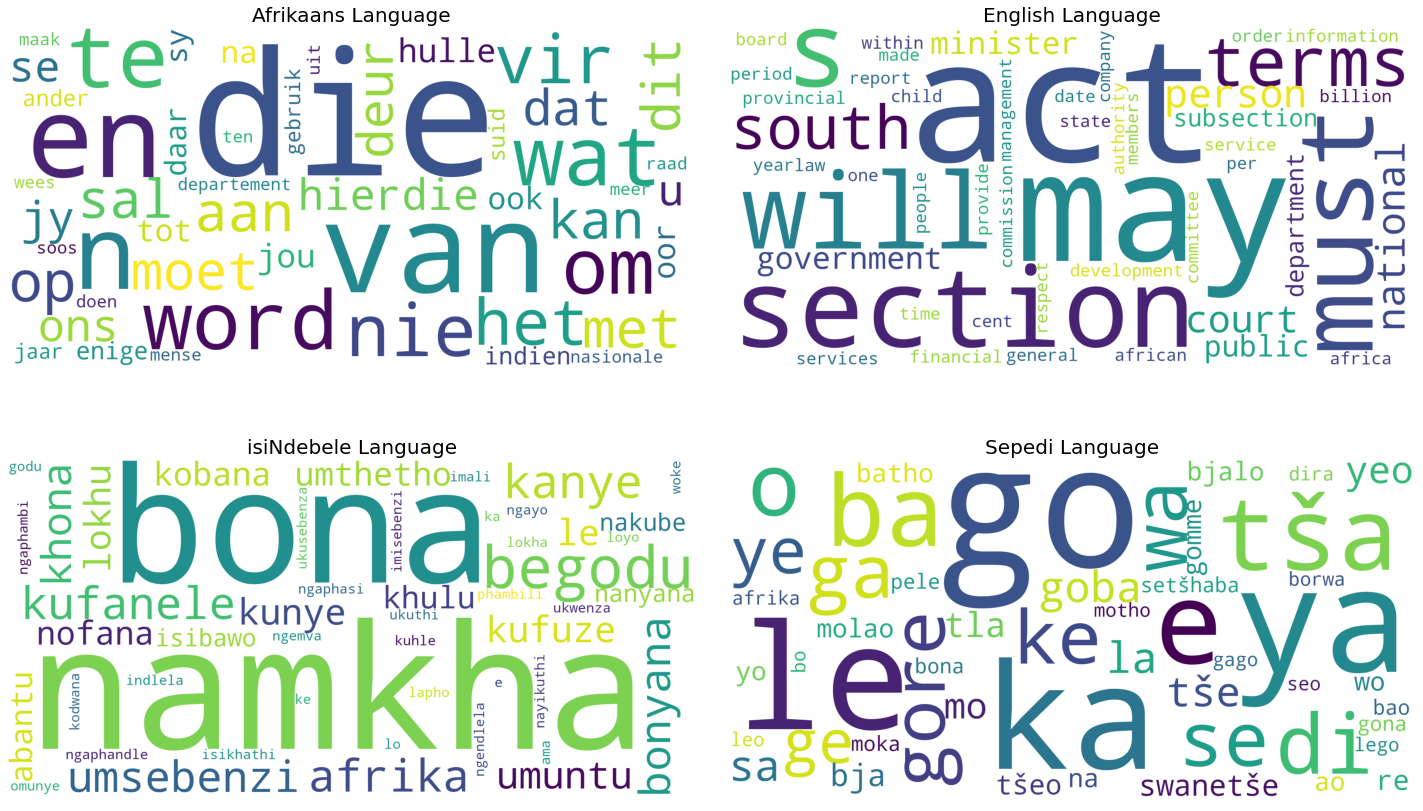

In [19]:
fig, axs = plt.subplots(2, 2, figsize = (20, 12))
# fig.suptitle('Clouds of polar words', fontsize = 30)

fig.tight_layout(pad = 0)
axs[0, 0].imshow(Afrikaans)
axs[0, 0].set_title('Afrikaans Language', fontsize = 20)
axs[0, 0].axis('off')

# axs[0, 0].tight_layout(pad = 1)
axs[0, 1].imshow(English)
axs[0, 1].set_title('English Language', fontsize = 20)
axs[0, 1].axis('off')

axs[1, 0].imshow(isiNdebele)
axs[1, 0].set_title('isiNdebele Language', fontsize = 20)
axs[1, 0].axis('off')

axs[1, 1].imshow(Sepedi)
axs[1, 1].set_title('Sepedi Language', fontsize = 20)
axs[1, 1].axis('off')

plt.savefig('joint_cloud.png')

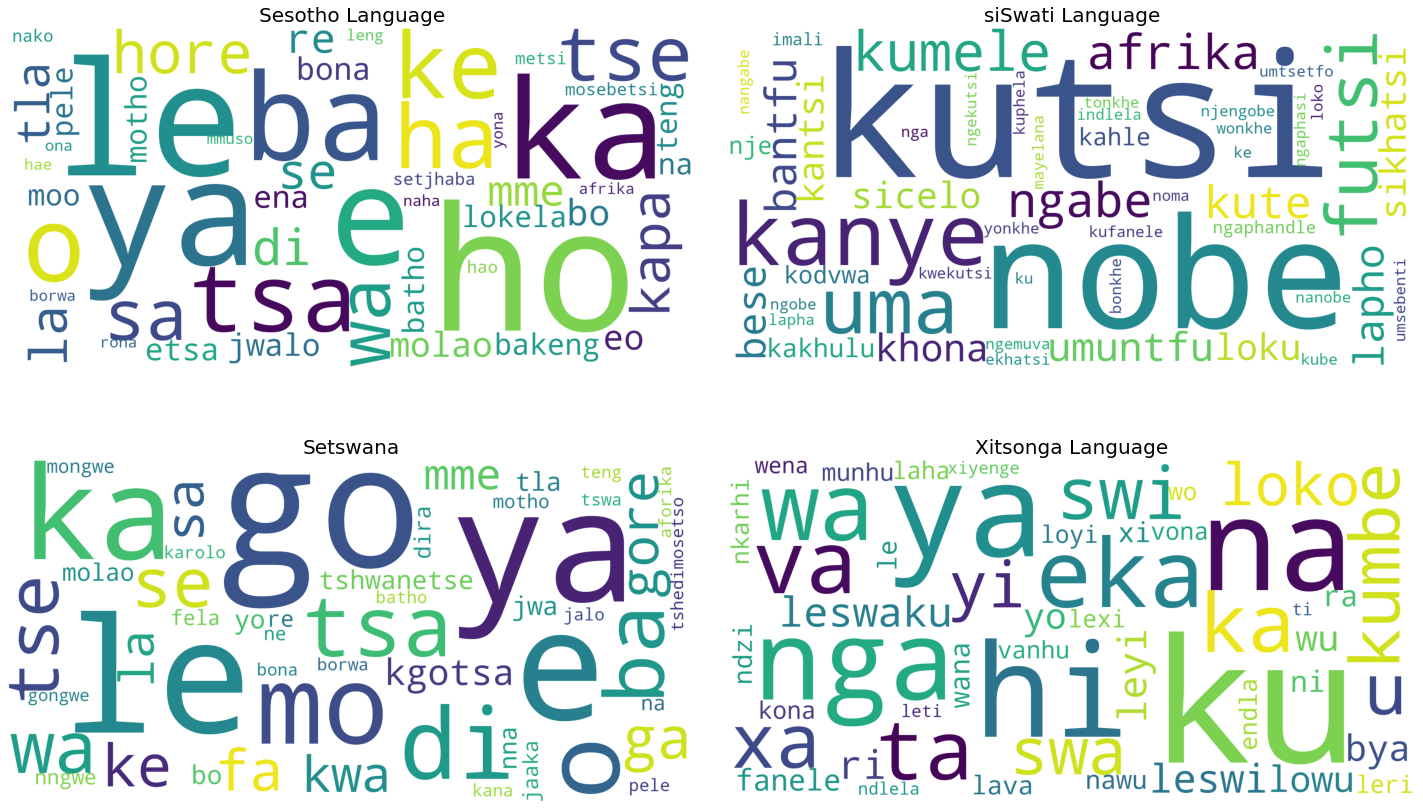

In [20]:
fig, axs = plt.subplots(2, 2, figsize = (20, 12))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(Sesotho)
axs[0, 0].set_title('Sesotho Language', fontsize = 20)
axs[0, 0].axis('off')

# axs[0, 0].tight_layout(pad = 1)
axs[0, 1].imshow(siSwati)
axs[0, 1].set_title('siSwati Language', fontsize = 20)
axs[0, 1].axis('off')

axs[1, 0].imshow(Setswana)
axs[1, 0].set_title('Setswana', fontsize = 20)
axs[1, 0].axis('off')

axs[1, 1].imshow(Xitsonga)
axs[1, 1].set_title('Xitsonga Language', fontsize = 20)
axs[1, 1].axis('off')

plt.savefig('joint_cloud.png')

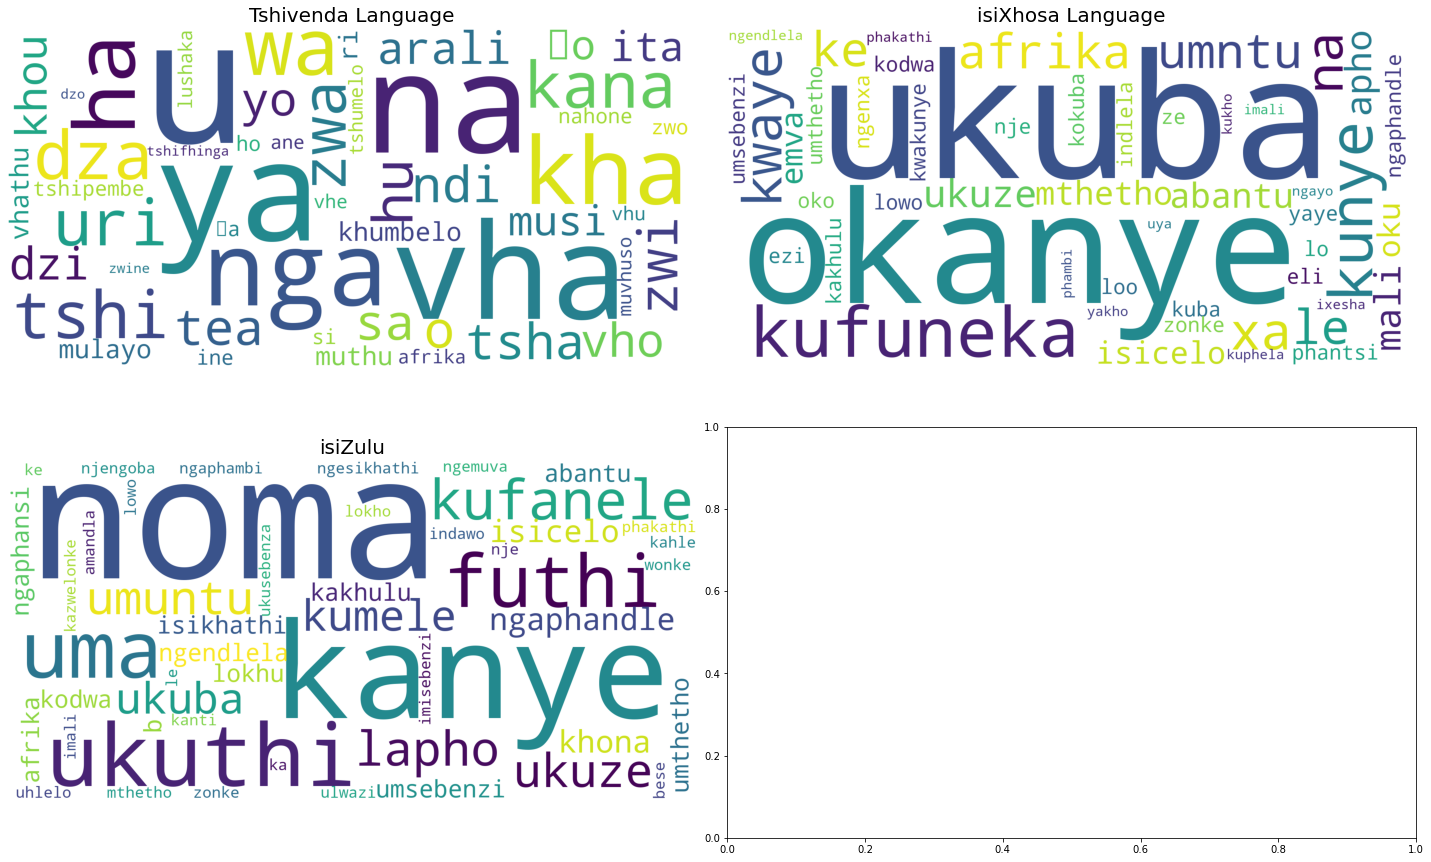

In [21]:
#Afrikaans, English, isiNdebele, Sepedi, Sesotho, siSwati, Setswana, 
#Xitsonga, Tshivenda, isiXhosa, isiZulu]
fig, axs = plt.subplots(2, 2, figsize = (20, 12))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(Tshivenda)
axs[0, 0].set_title('Tshivenda Language', fontsize = 20)
axs[0, 0].axis('off')

# axs[0, 0].tight_layout(pad = 1)
axs[0, 1].imshow(isiXhosa)
axs[0, 1].set_title('isiXhosa Language', fontsize = 20)
axs[0, 1].axis('off')

axs[1, 0].imshow(isiZulu)
axs[1, 0].set_title('isiZulu', fontsize = 20)
axs[1, 0].axis('off')

plt.savefig('joint_cloud.png')

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


Machine Learning Models cannot understand characters and words; they only understand numerical data. So when dealing with text data we need to represent it in numbers to be understood by our models.    
In this stage of our predict project, we will;    
- convert our target label which is in characters(object) to numerical(integer) using one of our imported tools `LabelEncoder`.
- Perform vectorization on our text feature.
- Do a train test split on our feature and target variables.
- Select our best features for training our model using SelectKbest feature selection module.

In [22]:
#select the feature and the target variable
X = lang_data_train['digit_removed_text']
y = lang_data_train['lang_id']
X_unseen = lang_data_test['digit_removed_text']

**Note:** I chose this Independent feature as my **X** to be vectorized and split because after some individual testings and 'trial-and-errors' when training my models, I observed that this feature was most helpful.

#### Label Encoding
See what our target label will look like when categorized with `LabelEncoder`.

In [23]:
# initializing labelEncoder
le = LabelEncoder()
#transform the target variable to numbers
y_df = pd.DataFrame(y)
y_df['Language_Id_Category'] = le.fit_transform(y_df)

In [24]:
y_df.drop_duplicates(['lang_id'])

,lang_id,Language_Id_Category
0,xho,9
2,eng,1
3,nso,3
4,ven,8
6,tsn,6
10,nbl,2
12,zul,10
13,ssw,5
16,tso,7
18,sot,4


In [25]:
#instantiation of labelEncoder
le = LabelEncoder()
#transform the target variable to numbers
y = le.fit_transform(y)

#### Vectorizing 

A Vectorizer is a method to convert text to numerical data. These words will be converted and created as features, thereby making us have thousands of features in our dataset.     
Let us vectorize the text feature.

In [26]:
#using countVectoerizer
vectorizer = CountVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))
#transforming the feature variable
vectorizer.fit(X)
X_vect = vectorizer.transform(X)
X_unseen_vect = vectorizer.transform(X_unseen)
#shape of the feature after applying the countvectorizer
print(X_vect.shape)
print(X_unseen_vect.shape)

(33000, 705275)
(5682, 705275)


Next, we will perform our `train_test_split`

In [27]:
# Split Data (into Training & Test)
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.10, random_state=0)

#### Using SelectKBest to select our best features       
`SelectKBest` is a feature selection module in which removes all but the _k_ highest scoring features according to some specified statistical test. We will be using this module to select the best features to train our model with which could be over a thousand.

In [28]:
# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=700000)

# Transform (i.e.: run selection on) the training data
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)
# Transform our testing data too
X_test_kbest = selector_kbest.transform(X_test)
unseen_kbest = selector_kbest.transform(X_unseen_vect)

print(X_train_kbest.shape)
print(X_test_kbest.shape)
print(unseen_kbest.shape)

(29700, 700000)
(3300, 700000)
(5682, 700000)


<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


#### Here in Model Building, we will:
- Build and train models like Logistic Regression, KNearest Neighbours(KNN), Support Vector Machines (SVM), Decision Trees, Random Forest, and Naive Bayes, then select the best model based on `F1-score`

In [29]:
# instanciating the models
log_reg_model = LogisticRegression(max_iter=1000)
naibay_model = MultinomialNB()
linsvc__model = LinearSVC()
knn_model = KNeighborsClassifier()
dec_tree_model = DecisionTreeClassifier(random_state=42)

In [30]:
log_reg_model = log_reg_model.fit(X_train_kbest, y_train)
naibay_model = naibay_model.fit(X_train_kbest, y_train)
linsvc__model = linsvc__model.fit(X_train_kbest, y_train)
knn_model = knn_model.fit(X_train_kbest, y_train)
dec_tree_model = dec_tree_model.fit(X_train_kbest, y_train)

In [31]:
log_reg_predict = log_reg_model.predict(X_test_kbest)
nai_bay_predict = naibay_model.predict(X_test_kbest)
lin_svc__predict = linsvc__model.predict(X_test_kbest)
knn_predict = knn_model.predict(X_test_kbest)
dec_tree_predict = dec_tree_model.predict(X_test_kbest)

In [33]:
print('LOGISTIC REGRESSION')
print(classification_report(y_test, log_reg_predict, target_names=['afr', 'eng', 'nbl', 'nso', 
                                                                'sot', 'ssw', 'tsn', 'tso', 'ven', 'xho', 'zul']))

print('NAIVE BAYES')
print(classification_report(y_test, nai_bay_predict, target_names=['afr', 'eng', 'nbl', 'nso', 
                                                              'sot', 'ssw', 'tsn', 'tso', 'ven', 'xho', 'zul']))

print('LINEAR SUPPORT VECTOR')
print(classification_report(y_test, lin_svc__predict, target_names=['afr', 'eng', 'nbl', 'nso', 
                                                               'sot', 'ssw', 'tsn', 'tso', 'ven', 'xho', 'zul']))

print('K-NEAREST NEIGHBOURS')
print(classification_report(y_test, knn_predict, target_names=['afr', 'eng', 'nbl', 'nso', 
                                                                 'sot', 'ssw', 'tsn', 'tso', 'ven', 'xho', 'zul']))

print('DECISION TREE CLASSIFIER')
print(classification_report(y_test, dec_tree_predict, target_names=['afr', 'eng', 'nbl', 'nso', 
                                                               'sot', 'ssw', 'tsn', 'tso', 'ven', 'xho', 'zul']))


LOGISTIC REGRESSION
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       300
         eng       0.99      1.00      0.99       272
         nbl       0.99      0.98      0.99       312
         nso       1.00      1.00      1.00       277
         sot       1.00      0.99      0.99       299
         ssw       1.00      0.99      1.00       320
         tsn       0.99      1.00      1.00       295
         tso       1.00      1.00      1.00       299
         ven       1.00      1.00      1.00       306
         xho       1.00      0.99      1.00       308
         zul       0.98      0.98      0.98       312

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300

NAIVE BAYES
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       300
         eng       1.00      1.00      1.00   

Our models performed really well, except for `K-NEAREST NEIGHBOURS`. But we will choose `NAIVE BAYES` as our best model.

### Chosen Model Evaluation


In [34]:
# Naive Bayes model
#Set the parameters (alpha)
param_grid2 = {'alpha': [0.01, 0.03, 0.06, 0.09]}

# Grid Search on the Linear SVC model
gs_sv = GridSearchCV(MultinomialNB(), param_grid = [param_grid2])

# Fitting the model to our data
gs_sv.fit(X_train, y_train)

# Find the best estimator
gs_sv_best = gs_sv.best_estimator_

# Print the best parameters
print(gs_sv.best_params_)

# Print the best score
print(gs_sv.best_score_)

{'alpha': 0.03}
0.9992255892255892


In [38]:
print("\nResults\nConfusion matrix \n {}".format(
    confusion_matrix(y_test, nai_bay_predict)))


Results
Confusion matrix 
 [[300   0   0   0   0   0   0   0   0   0   0]
 [  0 272   0   0   0   0   0   0   0   0   0]
 [  0   0 312   0   0   0   0   0   0   0   0]
 [  0   0   0 277   0   0   0   0   0   0   0]
 [  0   0   0   1 298   0   0   0   0   0   0]
 [  0   0   0   0   0 320   0   0   0   0   0]
 [  0   0   0   0   0   0 295   0   0   0   0]
 [  0   0   0   0   0   0   0 299   0   0   0]
 [  0   0   0   0   0   0   0   0 306   0   0]
 [  0   0   0   0   0   0   0   0   0 308   0]
 [  0   0   1   0   0   0   0   0   0   0 311]]


### Creating function to clean unseen data     
For future unseen data

In [45]:
def prepro_data(filepath):
    # Read csv file into dataframe 
    lang_data_train = pd.read_csv(filepath)

    lang_data_train['lowercase_text'] = lang_data_train['text'].str.lower() 
    def remove_punctuation(text):
        return ''.join([l for l in text if l not in string.punctuation])
    
    lang_data_train['digit_removed_text'] = lang_data_train['text'].str.replace('\d+', '')
    
    vectedd = vectorizer.transform(lang_data_train['digit_removed_text'])

    return vectedd

In [46]:
unseen_index = pd.read_csv("test_set.csv")

In [47]:
unseen_data = prepro_data("test_set.csv")

In [48]:
#transforming the prediction from numbers to word
prediction1 = le.inverse_transform(log_reg_predict)
prediction1

array(['sot', 'sot', 'sot', ..., 'zul', 'tso', 'ven'], dtype=object)

In [49]:
prediction2 = le.inverse_transform(nai_bay_predict)
prediction2

array(['sot', 'sot', 'sot', ..., 'zul', 'tso', 'ven'], dtype=object)

In [52]:
prediction3 = le.inverse_transform(lin_svc__predict)
prediction3

array(['sot', 'sot', 'sot', ..., 'zul', 'tso', 'ven'], dtype=object)

In [51]:
prediction4 = le.inverse_transform(dec_tree_predict)
prediction4

array(['sot', 'sot', 'sot', ..., 'zul', 'tso', 'ven'], dtype=object)

In [53]:
submission1 = pd.DataFrame(list(zip(unseen_index['index'], prediction1)), columns=['index', 'lang_id'])
submission2 = pd.DataFrame(list(zip(unseen_index['index'], prediction2)), columns=['index', 'lang_id'])
submission3 = pd.DataFrame(list(zip(unseen_index['index'], prediction3)), columns=['index', 'lang_id'])
submission4 = pd.DataFrame(list(zip(unseen_index['index'], prediction4)), columns=['index', 'lang_id'])

In [54]:
#saving the file as csv for submission
submission1.to_csv('submission1.csv', index=False, index_label=False)
submission2.to_csv('submission2.csv', index=False, index_label=False)
submission3.to_csv('submission3.csv', index=False, index_label=False)
submission4.to_csv('submission4.csv', index=False, index_label=False)

In [56]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/chuqudee/edsa-language-classification-hackathon-2022-challenge/5fe8648fde6a4d3da82644b1baf5bbcb
COMET INFO:   Parameters:
COMET INFO:     C                        : 1.0
COMET INFO:     algorithm                : auto
COMET INFO:     alpha                    : 0.03
COMET INFO:     analyzer                 : word
COMET INFO:     binary                   : False
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     class_prior              : 1
COMET INFO:     class_weight             : 1
COMET INFO:     criterion                : gini
COMET INFO:     cv                       : 1
COMET INFO:     decode_error             : strict
COMET INFO:     dtype                    : <class 'numpy.int64'>
COMET INFO:     dual                     : True
CO